**Chapter 14 – Recurrent Neural Networks**

_This notebook contains all the sample code and solutions to the exercices in chapter 14._

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import numpy.random as rnd
import os

# to make this notebook's output stable across runs
rnd.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

Then of course we will need TensorFlow:

In [2]:
import tensorflow as tf

# Basic RNNs

## Manual RNN

In [3]:
tf.reset_default_graph()

n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons], dtype=tf.float32))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons, n_neurons], dtype=tf.float32))
b = tf.Variable(tf.zeros([1, n_neurons], dtype=tf.float32))

Y0 = tf.tanh(tf.matmul(X0, Wx) + b)
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X1, Wx) + b)

init = tf.global_variables_initializer()

In [4]:
X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]) # t = 0
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]]) # t = 1

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [5]:
print(Y0_val)

[[ 0.90123773  0.98922348 -0.6269781  -0.95980716  0.96048075]
 [ 0.98510647  1.         -1.         -1.          0.99918383]
 [ 0.9978351   1.         -1.         -1.          0.99998367]
 [-0.99988794  0.74807853 -1.         -1.         -0.45669135]]


In [6]:
print(Y1_val)

[[ 0.526667    1.         -1.         -1.          0.99992526]
 [-0.75961953 -0.91298747 -0.88291478  0.63755071  0.93126822]
 [-0.49365351  0.99999994 -1.         -1.          0.99859256]
 [-0.78534681  0.97880101 -1.         -0.99780411  0.76606095]]


## Using `rnn()`

In [7]:
tf.reset_default_graph()

n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, [X0, X1], dtype=tf.float32)
Y0, Y1 = output_seqs

init = tf.global_variables_initializer()

In [8]:
X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]])
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]])

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [9]:
Y0_val

array([[ 0.28662205,  0.30925247, -0.1196948 , -0.75895321, -0.75996983],
       [ 0.92597973, -0.33076611, -0.96472853, -0.98375559, -0.98610842],
       [ 0.99468613, -0.76455796, -0.99918038, -0.99902183, -0.99928272],
       [ 0.95082718, -0.96377665, -0.99991548, -0.84052283, -0.75621897]], dtype=float32)

In [10]:
Y1_val

array([[ 0.99884236, -0.98738086, -0.9999764 , -0.99626565, -0.99299222],
       [-0.50243556, -0.54109138, -0.51660717, -0.21931489,  0.73975986],
       [ 0.9268406 , -0.97699696, -0.99956453, -0.95843869, -0.75154305],
       [ 0.23540512, -0.91165251, -0.97869498, -0.45751983,  0.32356998]], dtype=float32)

In [11]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "b<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [12]:
show_graph(tf.get_default_graph())

## Packing sequences

In [13]:
tf.reset_default_graph()

n_steps = 2
n_inputs = 3
n_neurons = 5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
X_seqs = tf.unstack(tf.transpose(X, perm=[1, 0, 2]))

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, X_seqs, dtype=tf.float32)
outputs = tf.transpose(tf.stack(output_seqs), perm=[1, 0, 2])

init = tf.global_variables_initializer()

In [14]:
X_batch = np.array([
        # t = 0      t = 1 
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [15]:
print(np.transpose(outputs_val, axes=[1, 0, 2])[1])

[[-0.99997586 -0.9984535  -0.97207373  1.         -0.98778659]
 [ 0.6685614   0.30946875  0.28615698 -0.26904964  0.17949906]
 [-0.98333597 -0.9671362  -0.95749182  0.99999988 -0.93386269]
 [ 0.04539975 -0.66158098 -0.924348    0.9970457  -0.72605741]]


## Using `dynamic_rnn()`

In [16]:
tf.reset_default_graph()

n_steps = 2
n_inputs = 3
n_neurons = 5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

init = tf.global_variables_initializer()

In [17]:
X_batch = np.array([
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    print("outputs =", outputs.eval(feed_dict={X: X_batch}))

outputs = [[[ 0.91089129 -0.94467813 -0.78610015 -0.2072562   0.87156135]
  [ 0.9999826  -1.         -0.98544002 -0.24509563  0.99999911]]

 [[ 0.99924409 -0.99998862 -0.95882088 -0.38083813  0.99967498]
  [ 0.10089301  0.05244089 -0.79083717  0.1913105  -0.43539378]]

 [[ 0.99999392 -1.         -0.99264669 -0.5311721   0.9999994 ]
  [ 0.99748254 -0.99999666 -0.95003164  0.09894454  0.99949437]]

 [[-0.92399746 -0.99193859  0.98692715 -0.70353955  0.64058793]
  [-0.06186941 -0.91329038 -0.75373876  0.22729108  0.61128241]]]


In [18]:
show_graph(tf.get_default_graph())

## Setting the sequence lengths

In [19]:
tf.reset_default_graph()

n_steps = 2
n_inputs = 3
n_neurons = 5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
seq_length = tf.placeholder(tf.int32, [None])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, sequence_length=seq_length, dtype=tf.float32)

init = tf.global_variables_initializer()

In [20]:
X_batch = np.array([
        # step 0     step 1
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2 (padded with zero vectors)
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])
seq_length_batch = np.array([2, 1, 2, 2])

with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run(
        [outputs, states], feed_dict={X: X_batch, seq_length: seq_length_batch})

In [21]:
print(outputs_val)

[[[ 0.41179428  0.29480082 -0.74883091 -0.88012534 -0.8605451 ]
  [ 1.          0.99984318  0.44317675 -0.99918354 -0.99996698]]

 [[ 0.99728894  0.95559734 -0.64238489 -0.99710017 -0.99772489]
  [ 0.          0.          0.          0.          0.        ]]

 [[ 0.9999913   0.99810869 -0.50363076 -0.9999339  -0.99996555]
  [ 0.99993801  0.99758989 -0.29853091 -0.95755404 -0.9990595 ]]

 [[ 0.99875265  0.99980903  0.99960428  0.87195015 -0.13289271]
  [ 0.95478088  0.93650955  0.74239284 -0.6496219  -0.89700985]]]


In [22]:
print(states_val)

[[ 1.          0.99984318  0.44317675 -0.99918354 -0.99996698]
 [ 0.99728894  0.95559734 -0.64238489 -0.99710017 -0.99772489]
 [ 0.99993801  0.99758989 -0.29853091 -0.95755404 -0.9990595 ]
 [ 0.95478088  0.93650955  0.74239284 -0.6496219  -0.89700985]]


## Training a sequence classifier

Note: the book uses `tensorflow.contrib.layers.fully_connected()` rather than `tf.layers.dense()` (which did not exist when this chapter was written). It is now preferable to use `tf.layers.dense()`, because anything in the contrib module may change or be deleted without notice. The `dense()` function is almost identical to the `fully_connected()` function. The main differences relevant to this chapter are:
* several parameters are renamed: `scope` becomes `name`, `activation_fn` becomes `activation` (and similarly the `_fn` suffix is removed from other parameters such as `normalizer_fn`), `weights_initializer` becomes `kernel_initializer`, etc.
* the default `activation` is now `None` rather than `tf.nn.relu`.

In [23]:
tf.reset_default_graph()

n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

with tf.variable_scope("rnn", initializer=tf.contrib.layers.variance_scaling_initializer()):
    basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
    outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits = tf.layers.dense(states, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [24]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")
X_test = mnist.test.images.reshape((-1, n_steps, n_inputs))
y_test = mnist.test.labels

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [25]:
n_epochs = 100
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

0 Train accuracy: 0.98 Test accuracy: 0.9156
1 Train accuracy: 0.953333 Test accuracy: 0.9486
2 Train accuracy: 0.96 Test accuracy: 0.9551
3 Train accuracy: 0.973333 Test accuracy: 0.9582
4 Train accuracy: 0.973333 Test accuracy: 0.9629
5 Train accuracy: 0.973333 Test accuracy: 0.9673
6 Train accuracy: 0.96 Test accuracy: 0.9663
7 Train accuracy: 0.993333 Test accuracy: 0.9679
8 Train accuracy: 0.966667 Test accuracy: 0.9665
9 Train accuracy: 0.966667 Test accuracy: 0.9661
10 Train accuracy: 0.993333 Test accuracy: 0.9703
11 Train accuracy: 0.966667 Test accuracy: 0.9709
12 Train accuracy: 0.98 Test accuracy: 0.9755
13 Train accuracy: 0.973333 Test accuracy: 0.9746
14 Train accuracy: 0.953333 Test accuracy: 0.9715
15 Train accuracy: 1.0 Test accuracy: 0.9754
16 Train accuracy: 0.986667 Test accuracy: 0.9732
17 Train accuracy: 0.973333 Test accuracy: 0.9741
18 Train accuracy: 0.993333 Test accuracy: 0.9784
19 Train accuracy: 0.973333 Test accuracy: 0.9786
20 Train accuracy: 0.98 Test ac

# Multi-layer RNN

In [26]:
tf.reset_default_graph()

n_steps = 28
n_inputs = 28
n_neurons1 = 150
n_neurons2 = 100
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

hidden1 = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons1, activation=tf.nn.relu)
hidden2 = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons2, activation=tf.nn.relu)
multi_layer_cell = tf.contrib.rnn.MultiRNNCell([hidden1, hidden2])
outputs, states_tuple = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)
states = tf.concat(axis=1, values=states_tuple)
logits = tf.layers.dense(states, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [27]:
n_epochs = 100
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

0 Train accuracy: 0.966667 Test accuracy: 0.9281
1 Train accuracy: 0.986667 Test accuracy: 0.9575
2 Train accuracy: 0.966667 Test accuracy: 0.9626
3 Train accuracy: 0.986667 Test accuracy: 0.9694
4 Train accuracy: 0.973333 Test accuracy: 0.9746
5 Train accuracy: 0.986667 Test accuracy: 0.9734
6 Train accuracy: 0.973333 Test accuracy: 0.974
7 Train accuracy: 0.986667 Test accuracy: 0.9764
8 Train accuracy: 0.993333 Test accuracy: 0.9781
9 Train accuracy: 0.993333 Test accuracy: 0.9741
10 Train accuracy: 0.986667 Test accuracy: 0.9761
11 Train accuracy: 0.986667 Test accuracy: 0.9767
12 Train accuracy: 0.966667 Test accuracy: 0.9816
13 Train accuracy: 0.98 Test accuracy: 0.9788
14 Train accuracy: 0.986667 Test accuracy: 0.9792
15 Train accuracy: 0.973333 Test accuracy: 0.9798
16 Train accuracy: 1.0 Test accuracy: 0.9749
17 Train accuracy: 0.993333 Test accuracy: 0.9753
18 Train accuracy: 1.0 Test accuracy: 0.9851
19 Train accuracy: 1.0 Test accuracy: 0.9807
20 Train accuracy: 1.0 Test ac

# Time series

In [28]:
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

Saving figure time_series_plot


/home/ageron/dev/py/envs/ml/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


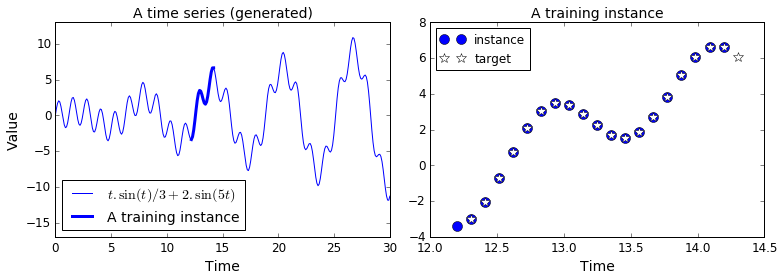

In [29]:
t = np.linspace(t_min, t_max, (t_max - t_min) // resolution)

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="A training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")


save_fig("time_series_plot")
plt.show()

In [30]:
X_batch, y_batch = next_batch(1, n_steps)

In [31]:
np.c_[X_batch[0], y_batch[0]]

array([[ 0.3266291 , -0.97081587],
       [-0.97081587, -2.09298955],
       [-2.09298955, -2.84017944],
       [-2.84017944, -3.10464787],
       [-3.10464787, -2.89622372],
       [-2.89622372, -2.33910087],
       [-2.33910087, -1.64063575],
       [-1.64063575, -1.03979198],
       [-1.03979198, -0.74786335],
       [-0.74786335, -0.89599678],
       [-0.89599678, -1.50237198],
       [-1.50237198, -2.46708161],
       [-2.46708161, -3.59597343],
       [-3.59597343, -4.64762444],
       [-4.64762444, -5.39195331],
       [-5.39195331, -5.66612695],
       [-5.66612695, -5.41407933],
       [-5.41407933, -4.69997176],
       [-4.69997176, -3.69230347],
       [-3.69230347, -2.6225661 ]])

## Using an `OuputProjectionWrapper`

In [32]:
tf.reset_default_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

n_outputs = 1
learning_rate = 0.001

loss = tf.reduce_sum(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [33]:
n_iterations = 1000
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    print(y_pred)

0 	MSE: 18105.6
100 	MSE: 627.721
200 	MSE: 312.021
300 	MSE: 141.915
400 	MSE: 100.223
500 	MSE: 63.7294
600 	MSE: 53.6281
700 	MSE: 55.9866
800 	MSE: 61.5282
900 	MSE: 60.0103
[[[-3.48736715]
  [-2.54926825]
  [-1.2468276 ]
  [ 0.55057281]
  [ 2.08766317]
  [ 3.12767291]
  [ 3.52064586]
  [ 3.33448243]
  [ 2.78682923]
  [ 2.13929224]
  [ 1.65987778]
  [ 1.48081505]
  [ 1.88019645]
  [ 2.71671796]
  [ 3.864393  ]
  [ 5.09236956]
  [ 6.07132006]
  [ 6.60731411]
  [ 6.57813835]
  [ 5.98707247]]]


Saving figure time_series_pred_plot


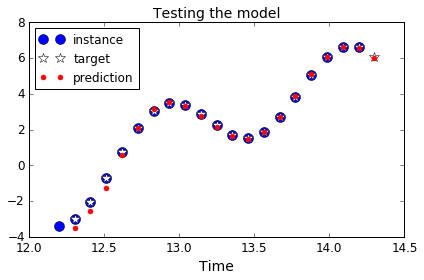

In [34]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

save_fig("time_series_pred_plot")
plt.show()

## Without using an `OutputProjectionWrapper`

In [35]:
tf.reset_default_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
rnn_outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

n_outputs = 1
learning_rate = 0.001

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

loss = tf.reduce_sum(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [36]:
n_iterations = 1000
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    print(y_pred)

0 	MSE: 14049.4
100 	MSE: 486.543
200 	MSE: 176.595
300 	MSE: 77.5854
400 	MSE: 62.1718
500 	MSE: 51.6699
600 	MSE: 55.632
700 	MSE: 48.0913
800 	MSE: 51.8524
900 	MSE: 42.9283
[[[-3.44116426]
  [-2.50117278]
  [-1.02837551]
  [ 0.6847741 ]
  [ 2.11391187]
  [ 3.0932982 ]
  [ 3.51630306]
  [ 3.4110744 ]
  [ 2.8878057 ]
  [ 2.20357442]
  [ 1.67804587]
  [ 1.52865112]
  [ 1.89587581]
  [ 2.71382356]
  [ 3.91365337]
  [ 5.1154604 ]
  [ 6.10716248]
  [ 6.66573906]
  [ 6.65902996]
  [ 6.09725142]]]


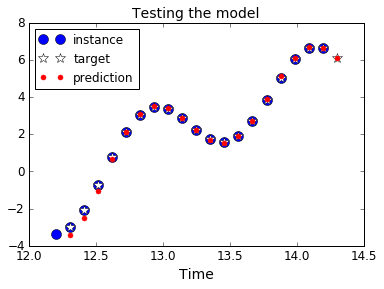

In [37]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

## Generating a creative new sequence

0 	MSE: 19680.3
100 	MSE: 570.373
200 	MSE: 266.971
300 	MSE: 86.2618
400 	MSE: 86.6934
500 	MSE: 50.9602
600 	MSE: 51.4026
700 	MSE: 48.2021
800 	MSE: 45.0193
900 	MSE: 40.7775
1000 	MSE: 48.967
1100 	MSE: 46.6544
1200 	MSE: 49.4276
1300 	MSE: 39.5498
1400 	MSE: 50.0555
1500 	MSE: 46.4711
1600 	MSE: 52.2085
1700 	MSE: 47.5045
1800 	MSE: 44.0871
1900 	MSE: 51.6531


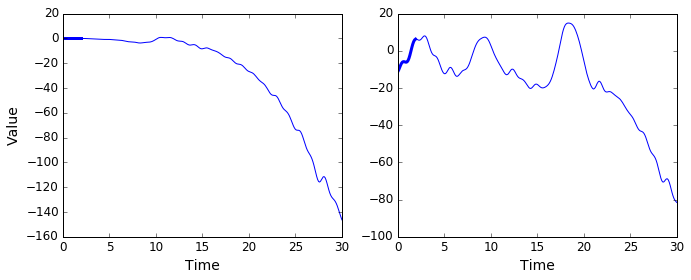

In [38]:
n_iterations = 2000
batch_size = 50
with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)

    sequence1 = [0. for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence1[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence1.append(y_pred[0, -1, 0])

    sequence2 = [time_series(i * resolution + t_min + (t_max-t_min/3)) for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence2[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence2.append(y_pred[0, -1, 0])

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(t, sequence1, "b-")
plt.plot(t[:n_steps], sequence1[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.plot(t, sequence2, "b-")
plt.plot(t[:n_steps], sequence2[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
#save_fig("creative_sequence_plot")
plt.show()

# Deep RNN

## MultiRNNCell

In [39]:
tf.reset_default_graph()

n_inputs = 2
n_neurons = 100
n_layers = 3
n_steps = 5
keep_prob = 0.5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
multi_layer_cell = tf.contrib.rnn.MultiRNNCell([basic_cell] * n_layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

init = tf.global_variables_initializer()

In [40]:
X_batch = rnd.rand(2, n_steps, n_inputs)

In [41]:
with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run([outputs, states], feed_dict={X: X_batch})

In [42]:
outputs_val.shape

(2, 5, 100)

## Dropout

In [43]:
tf.reset_default_graph()

n_inputs = 1
n_neurons = 100
n_layers = 3
n_steps = 20
n_outputs = 1

keep_prob = 0.5
learning_rate = 0.001

is_training = True

def deep_rnn_with_dropout(X, y, is_training):
    cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
    if is_training:
        cell = tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=keep_prob)
    multi_layer_cell = tf.contrib.rnn.MultiRNNCell([cell] * n_layers)
    rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

    stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
    stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
    outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

    loss = tf.reduce_sum(tf.square(outputs - y))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)

    return outputs, loss, training_op

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])
outputs, loss, training_op = deep_rnn_with_dropout(X, y, is_training)
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [44]:
n_iterations = 2000
batch_size = 50

with tf.Session() as sess:
    if is_training:
        init.run()
        for iteration in range(n_iterations):
            X_batch, y_batch = next_batch(batch_size, n_steps)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            if iteration % 100 == 0:
                mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
                print(iteration, "\tMSE:", mse)
        save_path = saver.save(sess, "/tmp/my_model.ckpt")
    else:
        saver.restore(sess, "/tmp/my_model.ckpt")
        X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
        y_pred = sess.run(outputs, feed_dict={X: X_new})
        
        plt.title("Testing the model", fontsize=14)
        plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
        plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
        plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
        plt.legend(loc="upper left")
        plt.xlabel("Time")
        plt.show()

0 	MSE: 12924.1
100 	MSE: 5977.86
200 	MSE: 4091.49
300 	MSE: 3568.85
400 	MSE: 3463.31
500 	MSE: 2903.24
600 	MSE: 3053.23
700 	MSE: 2951.54
800 	MSE: 2298.84
900 	MSE: 2261.7
1000 	MSE: 2539.72
1100 	MSE: 2244.54
1200 	MSE: 2662.65
1300 	MSE: 1727.08
1400 	MSE: 2257.1
1500 	MSE: 2755.52
1600 	MSE: 2684.77
1700 	MSE: 2165.59
1800 	MSE: 1599.96
1900 	MSE: 1763.45


# LSTM

In [45]:
tf.reset_default_graph()

n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
multi_cell = tf.contrib.rnn.MultiRNNCell([lstm_cell]*3)
outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)
top_layer_h_state = states[-1][1]
logits = tf.layers.dense(top_layer_h_state, n_outputs, name="softmax")
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()

In [46]:
states

(LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_2:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 150) dtype=float32>),
 LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_4:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_5:0' shape=(?, 150) dtype=float32>),
 LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_6:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_7:0' shape=(?, 150) dtype=float32>))

In [47]:
top_layer_h_state

<tf.Tensor 'rnn/while/Exit_7:0' shape=(?, 150) dtype=float32>

In [48]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((batch_size, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print("Epoch", epoch, "Train accuracy =", acc_train, "Test accuracy =", acc_test)

Epoch 0 Train accuracy = 0.966667 Test accuracy = 0.9485
Epoch 1 Train accuracy = 0.98 Test accuracy = 0.9715
Epoch 2 Train accuracy = 0.96 Test accuracy = 0.9693
Epoch 3 Train accuracy = 0.986667 Test accuracy = 0.9789
Epoch 4 Train accuracy = 0.986667 Test accuracy = 0.983
Epoch 5 Train accuracy = 1.0 Test accuracy = 0.9828
Epoch 6 Train accuracy = 0.993333 Test accuracy = 0.9846
Epoch 7 Train accuracy = 0.993333 Test accuracy = 0.9832
Epoch 8 Train accuracy = 0.993333 Test accuracy = 0.988
Epoch 9 Train accuracy = 1.0 Test accuracy = 0.9872


# Distributing layers across devices

In [49]:
import tensorflow as tf

class DeviceCellWrapper(tf.contrib.rnn.RNNCell):
  def __init__(self, device, cell):
    self._cell = cell
    self._device = device

  @property
  def state_size(self):
    return self._cell.state_size

  @property
  def output_size(self):
    return self._cell.output_size

  def __call__(self, inputs, state, scope=None):
    with tf.device(self._device):
        return self._cell(inputs, state, scope)

In [50]:
tf.reset_default_graph()

n_inputs = 5
n_neurons = 100
devices = ["/cpu:0"]*5
n_steps = 20
X = tf.placeholder(tf.float32, shape=[None, n_steps, n_inputs])
lstm_cells = [DeviceCellWrapper(device, tf.contrib.rnn.BasicRNNCell(num_units=n_neurons))
              for device in devices]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)
init = tf.global_variables_initializer()

In [51]:
with tf.Session() as sess:
    init.run()
    print(sess.run(outputs, feed_dict={X: rnd.rand(2, n_steps, n_inputs)}))

[[[ 0.05674776 -0.04305125  0.05370279 ..., -0.12256134 -0.02424083
    0.028048  ]
  [-0.16923295 -0.03783271 -0.03480514 ..., -0.02047317  0.16642918
   -0.04563583]
  [-0.04840624  0.11496866  0.2791242  ...,  0.34174094  0.36318955
    0.04168634]
  ..., 
  [-0.00508341 -0.25739726  0.60932404 ..., -0.63079047  0.09339754
   -0.59710467]
  [ 0.29252967  0.3760837   0.55276692 ..., -0.62108451  0.28393152
   -0.29904026]
  [-0.35599104 -0.47612086  0.74243373 ..., -0.34370166  0.13243021
   -0.29492998]]

 [[ 0.02094048 -0.04969998  0.05841689 ..., -0.15546556 -0.01198483
    0.03694121]
  [-0.15849786 -0.00336568  0.06917289 ...,  0.03318559  0.06535058
   -0.02117995]
  [ 0.00912648  0.03812006  0.27725378 ...,  0.20469114  0.3503969
    0.2177404 ]
  ..., 
  [ 0.06990141 -0.09845901  0.55926728 ..., -0.51187426 -0.05328218
   -0.33552352]
  [ 0.1207021  -0.43659616  0.60050225 ..., -0.33676812  0.26493025
   -0.65749478]
  [-0.20266469 -0.38161638  0.49859455 ...,  0.05017293  0.

# Embeddings

This section is based on TensorFlow's [Word2Vec tutorial](https://www.tensorflow.org/versions/r0.11/tutorials/word2vec/index.html).

## Fetch the data

In [52]:
from six.moves import urllib

import errno
import os
import zipfile

WORDS_PATH = "datasets/words"
WORDS_URL = 'http://mattmahoney.net/dc/text8.zip'

def mkdir_p(path):
    """Create directories, ok if they already exist.
    
    This is for python 2 support. In python >=3.2, simply use:
    >>> os.makedirs(path, exist_ok=True)
    """
    try:
        os.makedirs(path)
    except OSError as exc:
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

def fetch_words_data(words_url=WORDS_URL, words_path=WORDS_PATH):
    os.makedirs(words_path, exist_ok=True)
    zip_path = os.path.join(words_path, "words.zip")
    if not os.path.exists(zip_path):
        urllib.request.urlretrieve(words_url, zip_path)
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
    return data.decode("ascii").split()

In [53]:
words = fetch_words_data()

In [54]:
words[:5]

['anarchism', 'originated', 'as', 'a', 'term']

## Build the dictionary

In [55]:
from collections import Counter

vocabulary_size = 50000

vocabulary = [("UNK", None)] + Counter(words).most_common(vocabulary_size - 1)
vocabulary = np.array([word for word, _ in vocabulary])
dictionary = {word: code for code, word in enumerate(vocabulary)}
data = np.array([dictionary.get(word, 0) for word in words])

In [56]:
" ".join(words[:9]), data[:9]

('anarchism originated as a term of abuse first used',
 array([5238, 3083,   12,    6,  195,    2, 3136,   46,   59]))

In [57]:
" ".join([vocabulary[word_index] for word_index in [5241, 3081, 12, 6, 195, 2, 3134, 46, 59]])

'sitting inducted as a term of recipient first used'

In [58]:
words[24], data[24]

('culottes', 0)

## Generate batches

In [59]:
import random
from collections import deque

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

In [60]:
data_index=0
batch, labels = generate_batch(8, 2, 1)

In [61]:
batch, [vocabulary[word] for word in batch]

(array([3083, 3083,   12,   12,    6,    6,  195,  195], dtype=int32),
 ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term'])

In [62]:
labels, [vocabulary[word] for word in labels[:, 0]]

(array([[5238],
        [  12],
        [   6],
        [3083],
        [  12],
        [ 195],
        [   2],
        [   6]], dtype=int32),
 ['anarchism', 'as', 'a', 'originated', 'as', 'term', 'of', 'a'])

## Build the model

In [63]:
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = rnd.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

learning_rate = 0.01

In [64]:
tf.reset_default_graph()

# Input data.
train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

# Look up embeddings for inputs.
init_embeddings = tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)
embeddings = tf.Variable(init_embeddings)
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

# Construct the variables for the NCE loss
nce_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                        stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

# Compute the average NCE loss for the batch.
# tf.nce_loss automatically draws a new sample of the negative labels each
# time we evaluate the loss.
loss = tf.reduce_mean(
    tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed,
                   num_sampled, vocabulary_size))

# Construct the Adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

# Compute the cosine similarity between minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

# Add variable initializer.
init = tf.global_variables_initializer()

## Train the model

In [65]:
num_steps = 10001

with tf.Session() as session:
    init.run()

    average_loss = 0
    for step in range(num_steps):
        print("\rIteration: {}".format(step), end="\t")
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

        # We perform one update step by evaluating the training op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([training_op, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = vocabulary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log_str = "Nearest to %s:" % valid_word
                for k in range(top_k):
                    close_word = vocabulary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)

    final_embeddings = normalized_embeddings.eval()

Iteration: 0	Average loss at step  0 :  291.594116211
Nearest to on: rp, coast, uzbeks, pressurized, diana, hatchet, impure, spaceflight,
Nearest to have: avoiding, cushing, alde, atchison, optimally, passos, attachment, allophone,
Nearest to which: plausibility, egalitarian, learns, purple, comprising, underweight, whitey, buffering,
Nearest to in: redding, triplets, niz, textual, coloureds, aft, minefields, dt,
Nearest to if: imax, ailuropoda, vga, dragoons, scepticism, hispano, ipa, hallstatt,
Nearest to system: sucking, supplementation, beaverbrook, interlude, pcbs, recurring, stravinsky, payne,
Nearest to his: pastoral, ngos, theologiae, enlil, daewoo, russo, dawson, reinhard,
Nearest to war: specialize, freemason, brewery, peninsulas, godzilla, stanshall, megiddo, deflecting,
Nearest to would: monkey, jurisprudence, lieben, manages, celeste, nikki, agathon, ounces,
Nearest to a: downside, encephalopathy, cabinet, cortisol, mummy, partit, aleksander, gayle,
Nearest to over: ballpo

Let's save the final embeddings (of course you can use a TensorFlow `Saver` if you prefer):

In [66]:
np.save("./my_final_embeddings.npy", final_embeddings)

## Plot the embeddings

In [67]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

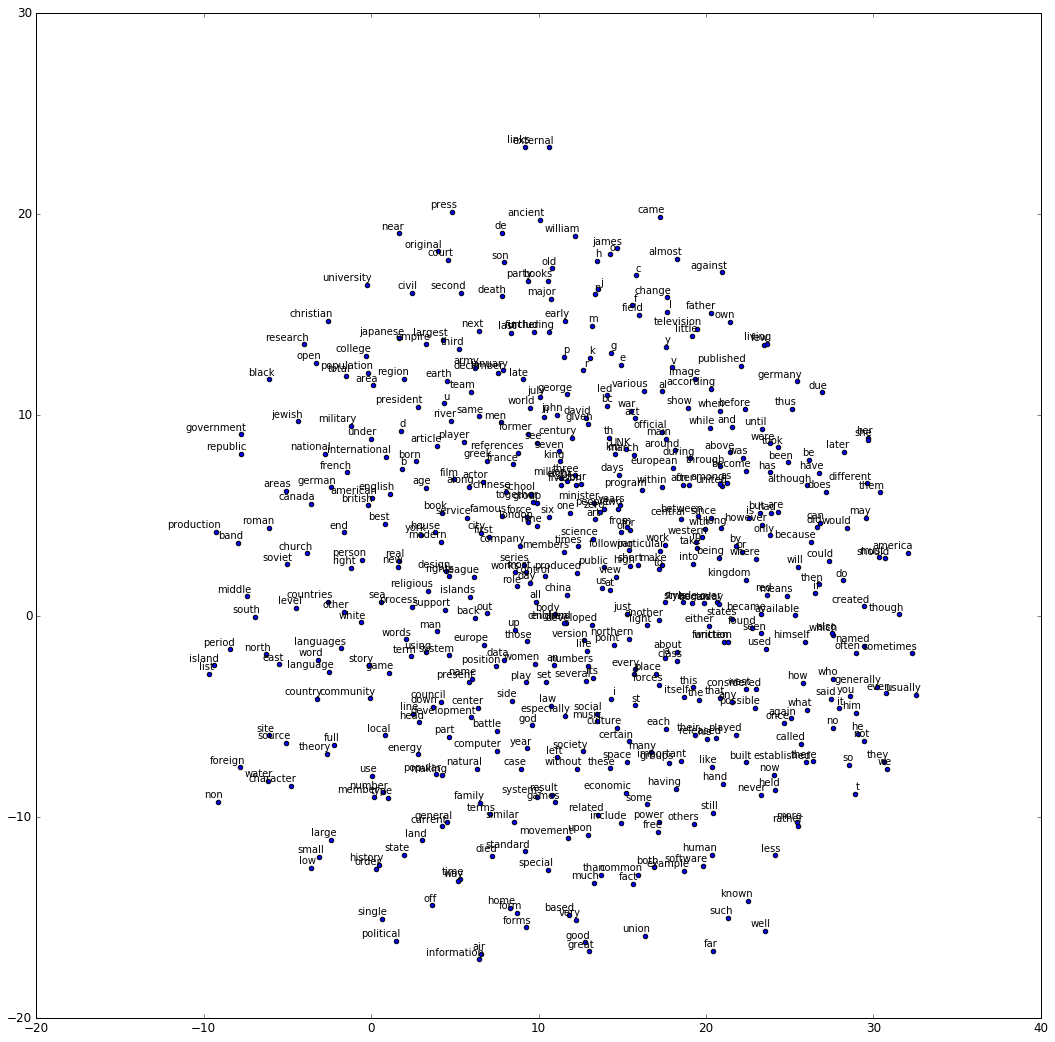

In [68]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [vocabulary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

# Machine Translation

The `basic_rnn_seq2seq()` function creates a simple Encoder/Decoder model: it first runs an RNN to encode `encoder_inputs` into a state vector, then runs a decoder initialized with the last encoder state on `decoder_inputs`. Encoder and decoder use the same RNN cell type but they don't share parameters.

In [69]:
import tensorflow as tf
tf.reset_default_graph()

n_steps = 50
n_neurons = 200
n_layers = 3
num_encoder_symbols = 20000
num_decoder_symbols = 20000
embedding_size = 150
learning_rate = 0.01

X = tf.placeholder(tf.int32, [None, n_steps]) # English sentences
Y = tf.placeholder(tf.int32, [None, n_steps]) # French translations
W = tf.placeholder(tf.float32, [None, n_steps - 1, 1])
Y_input = Y[:, :-1]
Y_target = Y[:, 1:]

encoder_inputs = tf.unstack(tf.transpose(X)) # list of 1D tensors
decoder_inputs = tf.unstack(tf.transpose(Y_input)) # list of 1D tensors

lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
cell = tf.contrib.rnn.MultiRNNCell([lstm_cell] * n_layers)

output_seqs, states = tf.contrib.legacy_seq2seq.embedding_rnn_seq2seq(
    encoder_inputs,
    decoder_inputs,
    cell,
    num_encoder_symbols,
    num_decoder_symbols,
    embedding_size)

logits = tf.transpose(tf.unstack(output_seqs), perm=[1, 0, 2])

In [70]:
logits_flat = tf.reshape(logits, [-1, num_decoder_symbols])
Y_target_flat = tf.reshape(Y_target, [-1])
W_flat = tf.reshape(W, [-1])
xentropy = W_flat * tf.nn.sparse_softmax_cross_entropy_with_logits(labels=Y_target_flat, logits=logits_flat)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

# Exercise solutions

**Coming soon**